In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import splrep
from scipy.interpolate import splev
from scipy.interpolate import UnivariateSpline
from matplotlib.gridspec import GridSpec

sns.set()

In [2]:
def vis_logprob(dados):
    x = np.sort(dados)
    y = np.arange(1, len(x)+1)/len(x)
    
    fig = plt.figure(figsize=(9,5))
    
    plt.grid(True, which="both")
    
    plt.axhline(np.median(dados), linestyle='--', label='Mediana', color='green', linewidth=0.5)
    plt.axhline(np.mean(dados), linestyle='--', label='Média', color='red', linewidth=0.5)
    plt.semilogy(y[::-1], x, 'o', markersize=1.5)
    plt.axvline(0.047, linestyle='--', color='orange', label='Limiar de Anomalia', linewidth=0.5)
    #plt.plot(0.073, 25.19, 'x', color='blue', label='Ponto de Inflexão')
    #plt.plot(0.32, 5.13, 'x', color='blue')
    plt.title(str(dados.name) +' Log x Probabilidade Acumulada')
    plt.xlabel('Probabilidade (%)')
    plt.ylabel(str(dados.name))
    plt.legend()
    
    plt.show()
    
    return x, y

In [3]:
dados = pd.read_excel('C:/Users/Pedro/Documents/Ufrj/Exploração Mineral/PMAsBi/Para de Minas2.xls')

In [4]:
dados_bi = dados['Bi (PPM)']
dados_as = dados['As (PPM)']

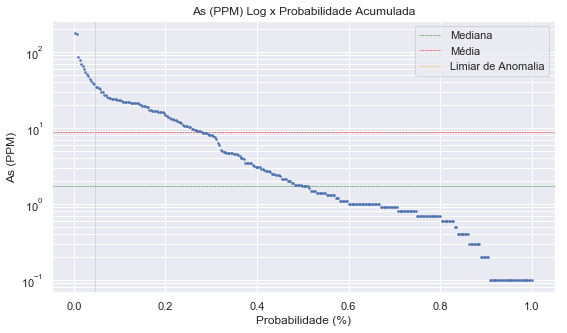

In [31]:
x, y = vis_logprob(dados_as)

### Criando Df

In [32]:
xy = pd.DataFrame()
xy.insert(loc=0, column='Teor', value=x)
xy.insert(loc=1, column='Prob', value=y[::-1])
xy.drop_duplicates(subset='Teor', inplace=True)

In [33]:
len(xy.Prob)

130

### Spline Cúbico

Limiar de 1º ordem: 0.012155012155012156
Limiar de 2º ordem: 0.013152835375057598
Limiar de 3º ordem: 0.04907447129669352
Limiar de 4º ordem: 0.05107011773678441
Limiar de 5º ordem: 0.06204617315728427


StopIteration: 

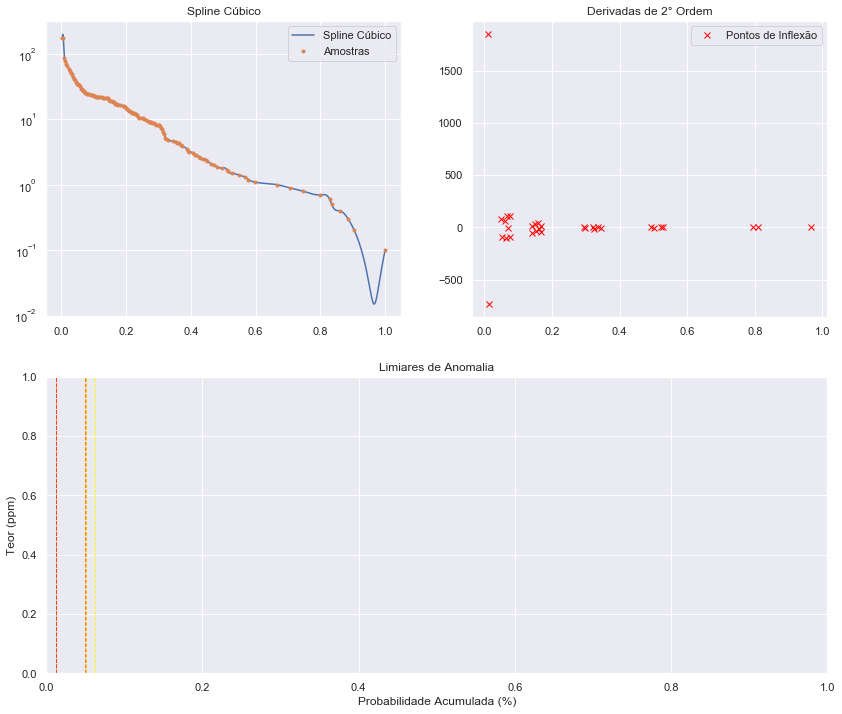

In [34]:
fig = plt.figure(figsize=(14,12))   # Crio a figura

spl = UnivariateSpline(xy.Prob[::-1], xy.Teor[::-1], k=3) # Spline de terceira ordem
spl.set_smoothing_factor(0)                             # Específico um smoothing factor

x_lin = np.linspace(np.min(xy.Prob[::-1]), np.max(xy.Prob[::-1]), 1000)   

spl_der2 = spl.derivative(1)
der2 = spl_der2(x_lin)

df_der = pd.DataFrame()                          
df_der.insert(loc=0, column='x', value=x_lin); df_der.insert(loc=1, column='der', value=der2)

sinal = np.sign(df_der.der)
troca_sinal = ((np.roll(sinal, 1) - sinal) != 0).astype(int)
df_der.insert(loc=2, column='sinal', value=troca_sinal)

gs = GridSpec(2, 2)

ax0 = plt.subplot(gs[1,:])
plt.title('Limiares de Anomalia')
plt.xlabel('Probabilidade Acumulada (%)')
plt.ylabel('Teor (ppm)')
ax1 = plt.subplot(gs[0,0])
plt.title('Spline Cúbico')
ax2 = plt.subplot(gs[0,1])
plt.title('Derivadas de 2° Ordem')

plt.grid(True, which="both")
ax1.semilogy(x_lin, spl(x_lin), label='Spline Cúbico')
ax1.semilogy(xy.Prob, xy.Teor, 'o', label='Amostras', markersize=3)
ax1.legend()

ax2.grid(True, which="both")
ax2.plot(df_der.x[df_der.sinal == 1][1::], df_der.der[df_der.sinal == 1][1::], 'x', color='red', label='Pontos de Inflexão')
ax2.legend()

ax0.grid(True, which="both")
ordem = 0
jet = plt.get_cmap('autumn')
colors = iter(jet(np.linspace(0,1,5)))
for limiar in df_der.x[df_der.sinal == 1][1::]:
    ordem += 1
    ax0.axvline(limiar, linestyle='--', label='Limiar de '+str(ordem)+'º ordem', color=next(colors), linewidth=1)
    print('Limiar de '+str(ordem)+'º ordem: '+str(limiar))
ax0.semilogy(x_lin, spl(x_lin), label='Spline Cúbico')
ax0.semilogy(xy.Prob, xy.Teor, 'o', label='Amostras', markersize=3)
ax0.legend()





plt.show()
plt.savefig('limiares.png')

In [51]:
#%matplotlib notebook
#
#plt.figure(figsize=(10, 8))
#plt.grid(True, which="both")
#
#spl.set_smoothing_factor(0.3)
#
##plt.plot(xy.Prob, xy.Teor, 'o', ms=1.5)
#plt.semilogy(x_lin, spl(x_lin), label='Spline Cúbico')

## Teste com Clustering:

In [41]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [48]:
valores = xy.values
scalar = preprocessing.MinMaxScaler()
valores_scalar = scalar.fit_transform(valores)
X = pd.DataFrame(valores_scalar)

In [50]:
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model=KMeans(n_clusters=k , random_state=3425)
    
    # Fit model to samples
    model.fit(X)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

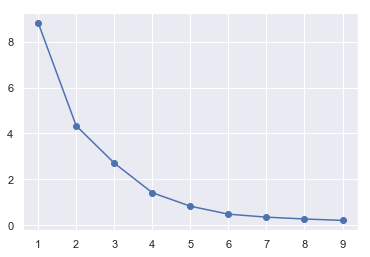

In [54]:
plt.plot(ks, inertias, '-o')